## 1단계 : 라벨 데이터 불러오기 및 이미지 경로 맵핑

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
import numpy as np
print(np.__version__)

1.26.4


In [5]:
# 현재 커널에 사이킷런 설치
import sys
!{sys.executable} -m pip install scikit-learn

In [6]:
!{sys.executable} -m pip install matplotlib

In [7]:
!{sys.executable} -m pip install Pillow

In [8]:
import pandas as pd

# CSV 파일 경로
label_path = "./labels.csv"  # 또는 "./labels.csv" 로 확장자까지 명시

# 라벨 데이터 읽기
labels_df = pd.read_csv(label_path)

# 미리보기
labels = labels_df['label'].values
labels = labels - 1
labels

array([ 76,  76,  76, ..., 101, 101, 101], dtype=int64)

In [9]:
import os
import tensorflow as tf

# tensorflow(3)에서의 tf_read_image, make_batch 함수를 하나의 함수로 제작
# 1. 이미지 로딩 함수 정의
def make_batch_and_tf_read_image(paths, target_size):
    images = []
    for path in paths:
        gfile = tf.io.read_file(path)
        image = tf.io.decode_image(gfile, dtype=tf.float32)  # 이미지 정규화 [0, 1]
        image = tf.image.resize(image, target_size)  # 사이즈 통일
        images.append(image)

    images_tf = tf.convert_to_tensor(images)
    return images_tf

# 2. 이미지 경로 설정
img_path = os.path.join(os.getcwd(), 'data', '*.jpg')  # ./data/*.jpg

# 3. 전체 이미지 경로 로딩
paths = tf.io.matching_files(img_path)

# 4. 이미지 로딩 실행
image_size = (64, 64)
all_img_data = make_batch_and_tf_read_image(paths, image_size)  # 함수 이름 수정됨
all_img_data

<tf.Tensor: shape=(7323, 64, 64, 3), dtype=float32, numpy=
array([[[[4.23529446e-01, 4.66666698e-01, 2.47058839e-01],
         [3.33517164e-01, 3.87040466e-01, 1.50122553e-01],
         [3.27879906e-01, 3.92248809e-01, 1.24632359e-01],
         ...,
         [3.45281884e-02, 4.23713252e-02, 0.00000000e+00],
         [3.36703435e-02, 4.15134802e-02, 9.19117709e-04],
         [5.09803966e-02, 5.88235334e-02, 7.84313772e-03]],

        [[4.41973060e-01, 4.85110313e-01, 2.54963249e-01],
         [4.05459672e-01, 4.61309016e-01, 2.13851884e-01],
         [3.92082691e-01, 4.56966162e-01, 1.85171098e-01],
         ...,
         [3.97977978e-02, 4.76409346e-02, 0.00000000e+00],
         [3.77048887e-02, 4.55480255e-02, 3.01585504e-04],
         [4.57107872e-02, 5.35539240e-02, 2.57352949e-03]],

        [[4.34987783e-01, 4.85232860e-01, 2.37500012e-01],
         [4.44995165e-01, 5.05950868e-01, 2.42476657e-01],
         [4.43414450e-01, 5.10673285e-01, 2.27605626e-01],
         ...,
         [

## 2단계 : 학습/검증/테스트 셋 분리

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 전체 이미지 수 자동 계산
num_images = all_img_data.shape[0]
labels = np.array(labels, dtype=np.int32)  # 리스트인 경우 배열로 변환

# 1차 분할: train(80%) / temp(20%)
train_idx, temp_idx = train_test_split(
    np.arange(num_images),
    test_size=0.2,
    random_state=10,
    stratify=labels
)

# 2차 분할: temp → val(10%) / test(10%)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=10,
    stratify=labels[temp_idx]
)

# 인덱스를 이용해 tf.gather로 데이터 분할
train_x = tf.gather(all_img_data, train_idx)
val_x = tf.gather(all_img_data, val_idx)
test_x = tf.gather(all_img_data, test_idx)

train_y = labels[train_idx]
val_y = labels[val_idx]
test_y = labels[test_idx]

train_y = to_categorical(train_y, num_classes=102)
val_y = to_categorical(val_y, num_classes=102)

# 결과 출력
print("Train:", train_x.shape, train_y.shape)
print("Val:  ", val_x.shape, val_y.shape)
print("Test: ", test_x.shape, test_y.shape)


Train: (5858, 64, 64, 3) (5858, 102)
Val:   (732, 64, 64, 3) (732, 102)
Test:  (733, 64, 64, 3) (733,)


In [11]:
np.shape(train_y)

(5858, 102)

## 3단계: CNN 모델 구성 및 학습

In [22]:
from tensorflow.keras import layers, models, optimizers

# 클래스 수 계산
num_classes = len(np.unique(labels))


# CNN 모델 정의
model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(64,64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same'))  # 추가 계층
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Conv Block 2
model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same'))  # 추가 계층
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Conv Block 3
model.add(layers.Conv2D(256, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.35))



# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(num_classes, activation='softmax'))

# 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 구조 확인
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_15 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 64, 64, 64)       

##  4단계: 모델 학습 코드 (model.fit)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 증강 적용된 학습용 제너레이터 생성
train_generator = datagen.flow(
    train_x, train_y,
    batch_size=8,
    shuffle=True
)

# 얼리 스탑핑 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',       # 기준 지표: 검증 손실
    patience=100,               # 개선되지 않는 에폭 수 (5회 연속)
    restore_best_weights=True # 가장 좋은 가중치 복원
)

# 모델 학습 시 콜백 적용
history = model.fit(
    train_generator,                   # 또는 (train_x, train_y)
    #steps_per_epoch=len(train_x) // 8,
    epochs=300,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping],       # 콜백 적용
    verbose=1
)


Epoch 1/300
733/733 [==============================] - 87s 119ms/step - loss: 4.0876 - accuracy: 0.0848 - val_loss: 3.6552 - val_accuracy: 0.1421
Epoch 2/300
733/733 [==============================] - 75s 103ms/step - loss: 3.9047 - accuracy: 0.1074 - val_loss: 3.5653 - val_accuracy: 0.1680
Epoch 3/300
733/733 [==============================] - 88s 120ms/step - loss: 3.7367 - accuracy: 0.1299 - val_loss: 3.3504 - val_accuracy: 0.1940
Epoch 4/300
733/733 [==============================] - 87s 119ms/step - loss: 3.6529 - accuracy: 0.1473 - val_loss: 3.4117 - val_accuracy: 0.1981
Epoch 5/300
733/733 [==============================] - 87s 119ms/step - loss: 3.5046 - accuracy: 0.1707 - val_loss: 3.0402 - val_accuracy: 0.2664
Epoch 6/300
733/733 [==============================] - 87s 119ms/step - loss: 3.4017 - accuracy: 0.1900 - val_loss: 3.1910 - val_accuracy: 0.2363
Epoch 7/300
733/733 [==============================] - 87s 118ms/step - loss: 3.3652 - accuracy: 0.1953 - val_loss: 3.0129 -

## 5단계: 학습 결과 시각화 (Loss & Accuracy)

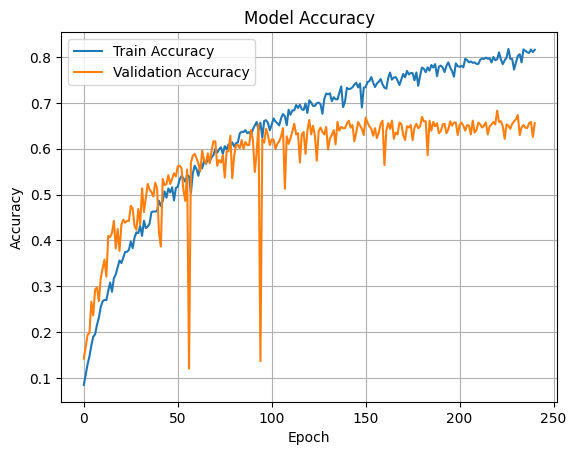

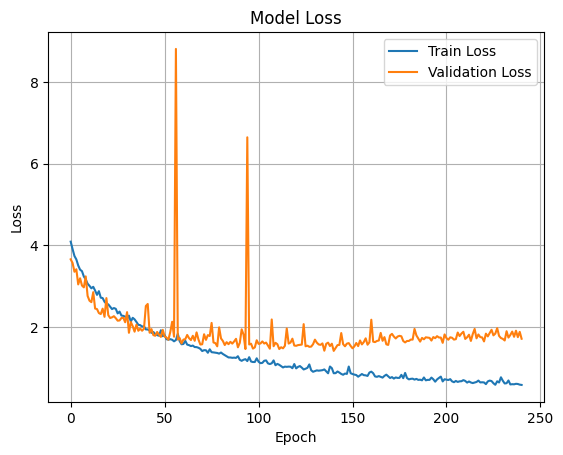

In [25]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

##  6단계: 테스트셋 평가 (model.evaluate())

In [27]:
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=1)

print(f" 테스트 정확도: {test_accuracy:.4f}")
print(f" 테스트 손실: {test_loss:.4f}")

ValueError: in user code:

    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\engine\training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\engine\training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\engine\training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\engine\training.py", line 1501, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\Wise02\.conda\envs\termproject\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 102) are incompatible


## 7단계: 학습된 모델 저장 (model.save())

In [ ]:
# 저장 파일명 설정 (예: 본인의 영어 이름)
save_path = 'hongsangwoo.h5'  # 예시: 홍상우 → hongsangwoo.h5

# 모델 저장
model.save(save_path)

print(f" 모델이 '{save_path}'로 저장되었습니다.")

In [ ]:
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기 테스트
loaded_model = load_model('hongsangwoo.h5')
print(" 모델이 정상적으로 로드되었습니다.")

##  8단계: 오분류 시각화, 혼동 행렬, 보고서 그래프 자동 생성 코드

In [ ]:
import sys
!{sys.executable} -m pip install seaborn

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical

# 예측
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# ✅ 혼동 행렬 생성
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ✅ 오분류 시각화 (최대 9개)
wrong_idx = np.where(y_pred_labels != y_true_labels)[0]
plt.figure(figsize=(8, 8))
for i, idx in enumerate(wrong_idx[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_labels[idx]}, Pred: {y_pred_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=16)
plt.show()

# ✅ 정확도, 정밀도, 재현율, F1-score 리포트 출력
print("\n[분류 리포트]")
print(classification_report(y_true_labels, y_pred_labels, zero_division=0))